# Grid Analysis

The purpose of this notebook is to leverage our cleaned datasets 'sprint_cleaned.csv' and 'race_cleaned.csv' to answer the following questions:
- Who are the Sprint vs. Grand Prix specialists? Are there any drivers who excel in both formats?
- What is the influence of the grid (starting) position in the Sprint vs. Grand Prix? Are there any conclusions to be made about driver's risk appetite in each format?

### Import Data and Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sprint_filtered = pd.read_csv(r'./sprint_cleaned.csv')
race_filtered = pd.read_csv(r'./race_cleaned.csv')
drivers = pd.read_csv(r'./F1_data/drivers.csv')

### Define method to calculate driver's metrics

In [30]:
def calculate_driver_metrics(sprint_df, race_df):
    # Aggregate performance metrics by driver
    sprint_metrics = sprint_df.groupby('driverId').agg({
        'positionOrder': 'mean',
        'grid': 'mean',
        'position_change': 'mean',
        'forename': 'first',
        'surname': 'first',
        'code': 'first'
    }).rename(columns={
        'positionOrder': 'avg_sprint_position',
        'grid': 'avg_sprint_grid',
        'position_change': 'avg_sprint_pos_change'
    })
    
    race_metrics = race_df.groupby('driverId').agg({
        'positionOrder': 'mean',
        'grid': 'mean',
        'position_change': 'mean'
    }).rename(columns={
        'positionOrder': 'avg_race_position',
        'grid': 'avg_race_grid',
        'position_change': 'avg_race_pos_change'
    })
    
    # Merge metrics
    combined_metrics = pd.merge(sprint_metrics, race_metrics, on='driverId', how='inner')
    
    # Calculate the difference between sprint and race performance
    combined_metrics['position_delta'] = combined_metrics['avg_sprint_position'] - combined_metrics['avg_race_position']
    combined_metrics['grid_delta'] = combined_metrics['avg_sprint_grid'] - combined_metrics['avg_race_grid']
    combined_metrics['position_change_delta'] = combined_metrics['avg_sprint_pos_change'] - combined_metrics['avg_race_pos_change']
    
    # Calculate sprint vs race preference score (negative values favor sprint, positive favor race)
    # A lower position is better, so we negate the position delta
    combined_metrics['format_preference_score'] = combined_metrics['position_delta']
    
    # Calculate consistency metrics (standard deviation of position)
    sprint_consistency = sprint_df.groupby('driverId')['positionOrder'].std().rename('sprint_position_std')
    race_consistency = race_df.groupby('driverId')['positionOrder'].std().rename('race_position_std')
    
    combined_metrics = pd.merge(combined_metrics, sprint_consistency, on='driverId', how='left')
    combined_metrics = pd.merge(combined_metrics, race_consistency, on='driverId', how='left')
    combined_metrics['consistency_delta'] = combined_metrics['sprint_position_std'] - combined_metrics['race_position_std']
    
    # Number of races/sprints participated in
    sprint_count = sprint_df.groupby('driverId').size().rename('sprint_count')
    race_count = race_df.groupby('driverId').size().rename('race_count')
    
    combined_metrics = pd.merge(combined_metrics, sprint_count, on='driverId', how='left')
    combined_metrics = pd.merge(combined_metrics, race_count, on='driverId', how='left')
    
    # Create full driver name
    combined_metrics['driver_name'] = combined_metrics['forename'] + ' ' + combined_metrics['surname']
    
    return combined_metrics

### Find Sprint and Grand Prix specialists

In [32]:
# Calculate metrics
driver_performance = calculate_driver_metrics(sprint_filtered, race_filtered)

# Identify Sprint vs GP specialists
# Sort by format preference score
sprint_specialists = driver_performance.sort_values('format_preference_score').head(5)
gp_specialists = driver_performance.sort_values('format_preference_score', ascending=False).head(5)

# Print results
print("Top Sprint Specialists (compared to their GP performance):")
print(sprint_specialists[['driver_name', 'code', 'avg_sprint_position', 'avg_race_position', 'format_preference_score']])

print("\nTop GP Specialists (compared to their Sprint performance):")
print(gp_specialists[['driver_name', 'code', 'avg_sprint_position', 'avg_race_position', 'format_preference_score']])

Top Sprint Specialists (compared to their GP performance):
               driver_name code  avg_sprint_position  avg_race_position  \
driverId                                                                  
817       Daniel Ricciardo  RIC             9.083333          13.166667   
857          Oscar Piastri  PIA             6.000000           9.916667   
832           Carlos Sainz  SAI             4.888889           8.611111   
856          Nyck de Vries  DEV            15.500000          18.500000   
1           Lewis Hamilton  HAM             6.777778           9.000000   

          format_preference_score  
driverId                           
817                     -4.083333  
857                     -3.916667  
832                     -3.722222  
856                     -3.000000  
1                       -2.222222  

Top GP Specialists (compared to their Sprint performance):
              driver_name code  avg_sprint_position  avg_race_position  \
driverId                     

### Plot difference between Sprint and GP positions

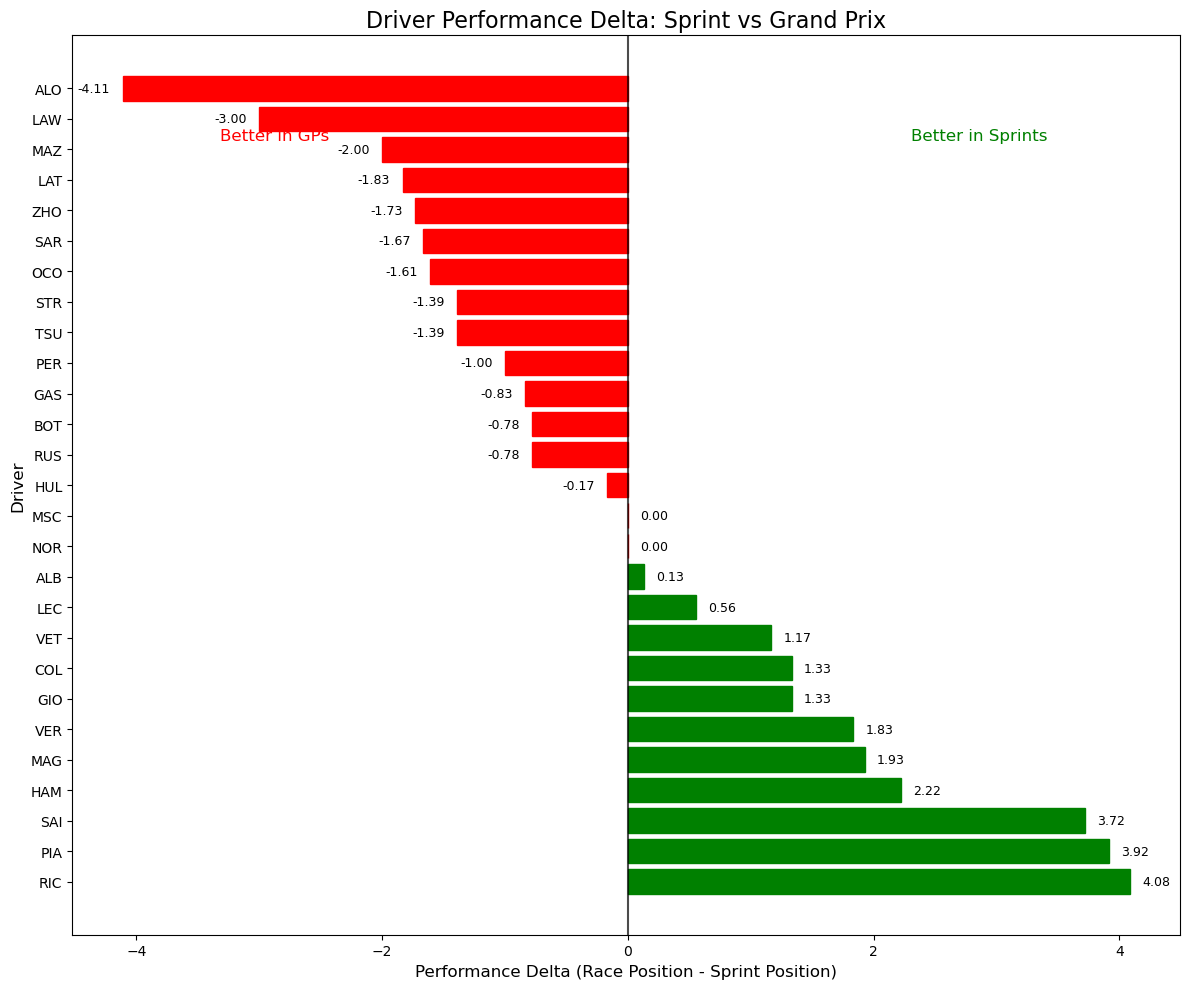

In [34]:
def calculate_driver_performance_delta(sprint_df, race_df):
    # Calculate average position for each driver in both formats
    sprint_avg = sprint_df.groupby('driverId').agg({
        'positionOrder': 'mean',
        'code': 'first',
        'forename': 'first',
        'surname': 'first'
    }).rename(columns={'positionOrder': 'avg_sprint_position'})
    
    race_avg = race_df.groupby('driverId').agg({
        'positionOrder': 'mean'
    }).rename(columns={'positionOrder': 'avg_race_position'})
    
    # Merge and calculate delta
    driver_delta = pd.merge(sprint_avg, race_avg, on='driverId', how='inner')
    driver_delta['performance_delta'] = driver_delta['avg_race_position'] - driver_delta['avg_sprint_position']
    driver_delta['driver_name'] = driver_delta['forename'] + ' ' + driver_delta['surname']
    
    # Calculate minimum race count for filtering
    sprint_count = sprint_df.groupby('driverId').size().rename('sprint_count')
    race_count = race_df.groupby('driverId').size().rename('race_count')
    driver_delta = pd.merge(driver_delta, sprint_count, on='driverId', how='left')
    driver_delta = pd.merge(driver_delta, race_count, on='driverId', how='left')
    
    # Filter drivers with at least 3 races in each format - Robert Kubica is filtered out
    min_races = 3
    driver_delta = driver_delta[(driver_delta['sprint_count'] >= min_races) & 
                               (driver_delta['race_count'] >= min_races)]
    
    return driver_delta

driver_performance_delta = calculate_driver_performance_delta(sprint_filtered, race_filtered)

def plot_driver_performance_delta(driver_delta_df):
    # Sort by delta
    sorted_df = driver_delta_df.sort_values('performance_delta', ascending=False)
    
    plt.figure(figsize=(12, 10))
    
    # Create horizontal bar chart
    bars = plt.barh(sorted_df['code'], sorted_df['performance_delta'], color='skyblue')
    
    # Color bars based on delta (positive = better at sprint, negative = better at GP)
    for i, bar in enumerate(bars):
        if sorted_df['performance_delta'].iloc[i] > 0:
            bar.set_color('green')
        else:
            bar.set_color('red')
    
    # Add vertical line at 0
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.7)
    
    # Add labels
    plt.xlabel('Performance Delta (Race Position - Sprint Position)', fontsize=12)
    plt.ylabel('Driver', fontsize=12)
    plt.title('Driver Performance Delta: Sprint vs Grand Prix', fontsize=16)
    
    # Add annotations
    plt.text(max(sorted_df['performance_delta']) * 0.7, len(sorted_df) * 0.9, 
             'Better in Sprints', fontsize=12, color='green', ha='center')
    plt.text(min(sorted_df['performance_delta']) * 0.7, len(sorted_df) * 0.9, 
             'Better in GPs', fontsize=12, color='red', ha='center')
    
    # Add value labels
    for i, v in enumerate(sorted_df['performance_delta']):
        plt.text(v + (0.1 if v >= 0 else -0.1), 
                 i, 
                 f"{v:.2f}", 
                 va='center',
                 ha='left' if v >= 0 else 'right',
                 fontsize=9)
    
    plt.tight_layout()
    return plt

driver_plot = plot_driver_performance_delta(driver_performance_delta)
plt.show()

### Plot driver's performance across formats

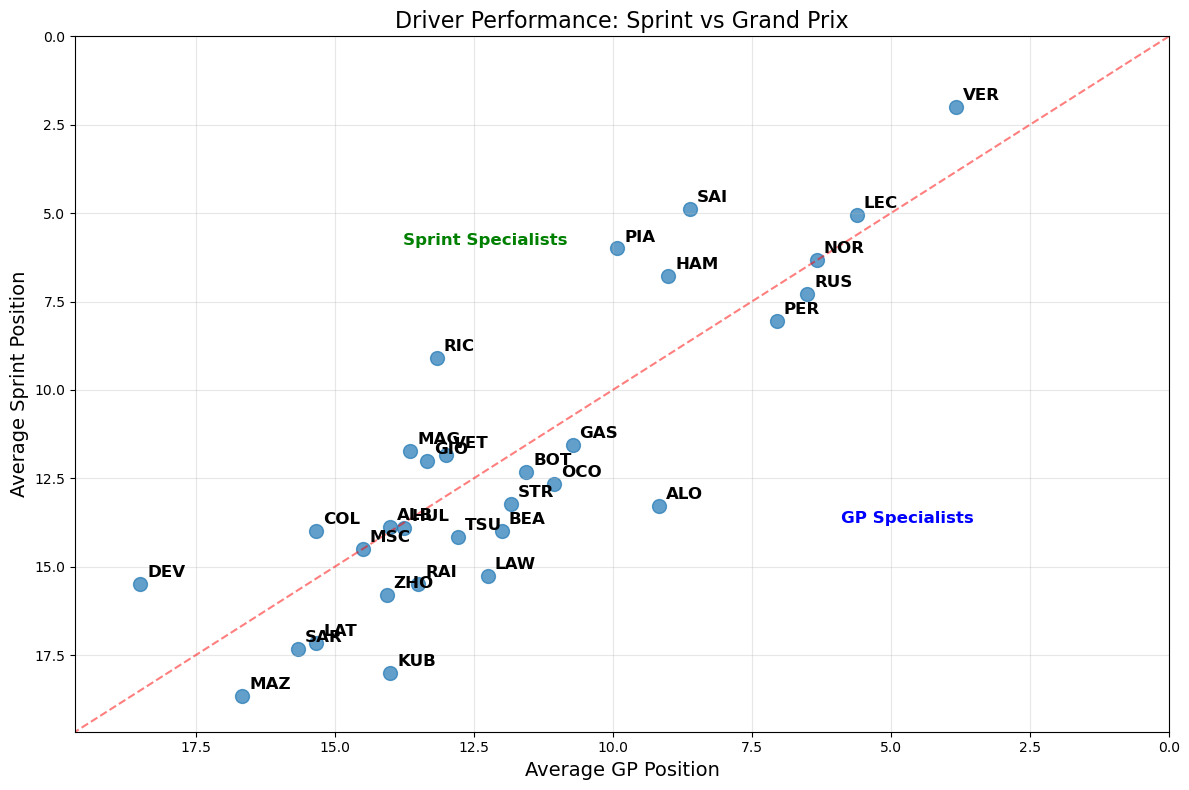

In [36]:
def plot_sprint_vs_gp_performance(metrics_df):
    plt.figure(figsize=(12, 8))
    
    # Create scatter plot
    plt.scatter(
        metrics_df['avg_race_position'], 
        metrics_df['avg_sprint_position'],
        s=100, alpha=0.7
    )
    
    # Add driver codes as labels
    for idx, row in metrics_df.iterrows():
        plt.annotate(
            row['code'], 
            (row['avg_race_position'], row['avg_sprint_position']),
            xytext=(5, 5), textcoords='offset points',
            fontsize=12, fontweight='bold'
        )
    
    # Add diagonal line (equal performance in both formats)
    max_val = max(
        metrics_df['avg_race_position'].max(),
        metrics_df['avg_sprint_position'].max()
    ) + 1
    plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
    
    # Annotations for specialists
    plt.annotate(
        'Sprint Specialists', 
        (max_val * 0.7, max_val * 0.3),
        fontsize=12, fontweight='bold', color='green'
    )
    plt.annotate(
        'GP Specialists', 
        (max_val * 0.3, max_val * 0.7),
        fontsize=12, fontweight='bold', color='blue'
    )
    
    # Labels and title
    plt.xlabel('Average GP Position', fontsize=14)
    plt.ylabel('Average Sprint Position', fontsize=14)
    plt.title('Driver Performance: Sprint vs Grand Prix', fontsize=16)
    
    # Invert axes (lower position is better)
    plt.xlim(max_val, 0)
    plt.ylim(max_val, 0)
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# Plot the results
plot = plot_sprint_vs_gp_performance(driver_performance)
plt.show()

### Plot grid vs. finising position of each driver across Sprint and Grand Prix

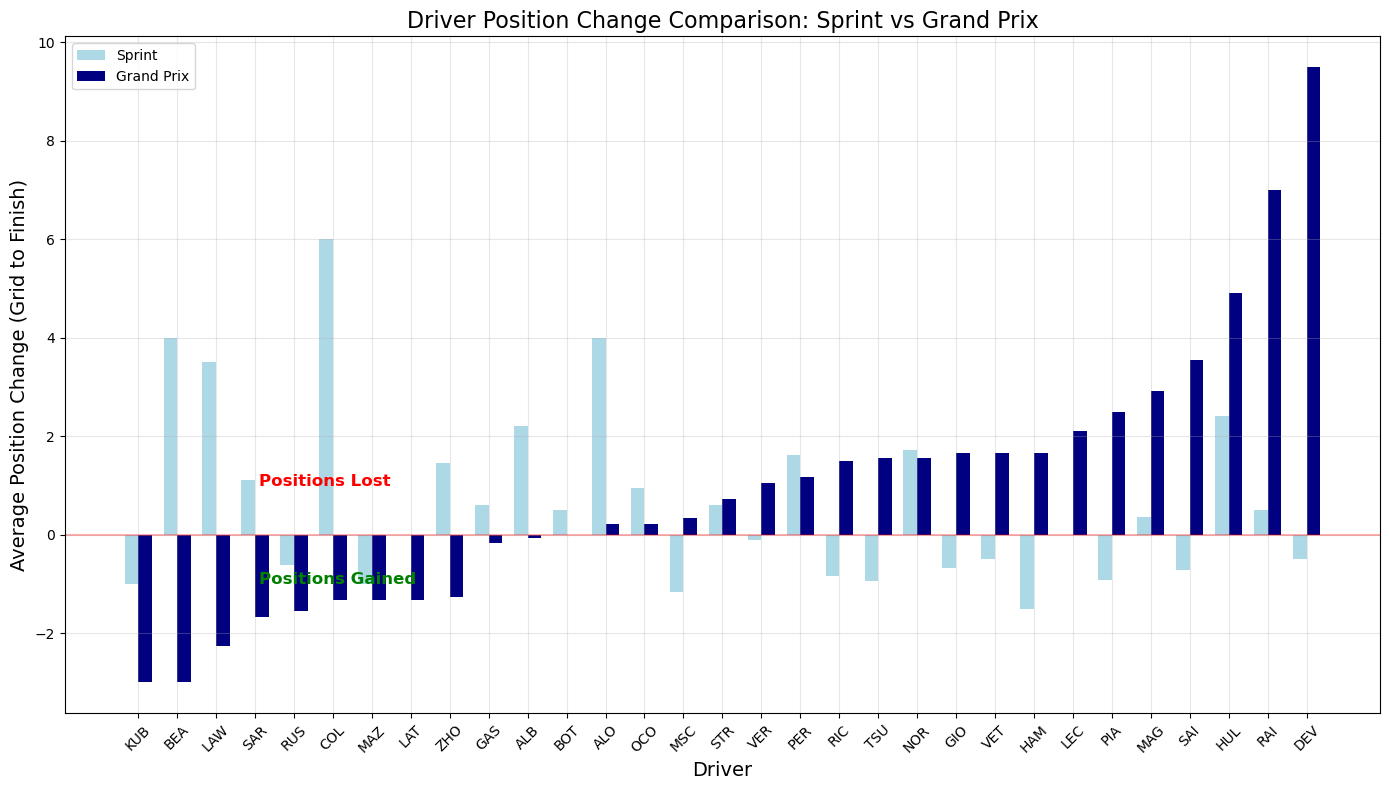

In [38]:
def plot_position_change_comparison(metrics_df):
    plt.figure(figsize=(14, 8))
    
    # Sort by GP position change
    sorted_drivers = metrics_df.sort_values('avg_race_pos_change')
    
    # Get driver codes in the sorted order
    drivers = sorted_drivers['code'].values
    
    # Create width for bars
    width = 0.35
    x = np.arange(len(drivers))
    
    # Create bars
    plt.bar(x - width/2, sorted_drivers['avg_sprint_pos_change'], width, label='Sprint', color='lightblue')
    plt.bar(x + width/2, sorted_drivers['avg_race_pos_change'], width, label='Grand Prix', color='navy')
    
    # Add labels and title
    plt.xlabel('Driver', fontsize=14)
    plt.ylabel('Average Position Change (Grid to Finish)', fontsize=14)
    plt.title('Driver Position Change Comparison: Sprint vs Grand Prix', fontsize=16)
    
    # Set x-ticks
    plt.xticks(x, drivers, rotation=45)
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    # Add legend
    plt.legend()
    
    # Add annotations for interpretation
    plt.annotate(
        'Positions Gained', 
        (len(drivers) * 0.1, -1),
        fontsize=12, fontweight='bold', color='green'
    )
    plt.annotate(
        'Positions Lost', 
        (len(drivers) * 0.1, 1),
        fontsize=12, fontweight='bold', color='red'
    )
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return plt

# Plot position change comparison
plot_change = plot_position_change_comparison(driver_performance)
plt.show()

## Insights

### Sprint vs. Grand-Prix specialists

As the data shows, **Daniel Ricciardo, Oscar Piastri, Carlos Sainz, Nyck de Vries and Lewis Hamilton are our top 5 _Sprint Specialists_**. This means that these drivers show the highest differences between their Sprint and Grand Prix performance over the last few seasons, with Ricciardo, Piastri and Sainz showing an average close to 4 positions gained in comparison to their Grand Prix finishing position. 

An interesting observation to be made on the plot is that **the highest performing drivers tend to fall neither on the Sprint or GP specialist line**. The plot points of Max Verstappen, Charles Leclerc, Lando Norris and George Russell all fall very near the dividing line of the two groups in the upper left corner, showing a **very small delta between the performance in the two formats**. 

### Grid Influence: Sprint vs. Grand-Prix

According to the results plotted, **the Grand-Prix format shows a higher difference between a driver's grid and finishing positions**. Not only that, but the overall tendency in the Grand-Prix is for drivers to lose positions. This displays a **higher risk appetite for drivers in the Grand Prix**, which makes sense considering the Grand-Prix awards more points for drivers - the bigger the risk, the bigger the reward. 